### Importing Libraries

In [1]:
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional, BatchNormalization

### Data Directory

In [2]:
data_directory = 'D:/Arrhythmia/Datas'

### Record Names

In [3]:
record_names = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
    '222', '223', '228', '230', '231', '232', '233', '234'
]

In [4]:
segment_length = 128

In [5]:
all_segments = []
all_labels = []

### Segmentation

In [6]:
for record_name in record_names:
    record_path = os.path.join(data_directory, record_name)
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')

        ecg_signal = record.p_signal.flatten()
        labels = annotation.sample

        label_mapping = {'N': 0, 'S': 1, 'V': 2, 'F': 3, '/': 4, 'Q': 5}
        numerical_labels = np.array([label_mapping[label] if label in label_mapping else 0 for label in annotation.symbol])

        def segment_data(signal, labels, segment_length=128):
            segments = []
            segment_labels = []
            for i in range(0, len(signal) - segment_length, segment_length):
                segment = signal[i:i + segment_length]
                lbl = labels[i:i + segment_length]
                if len(segment) == segment_length and np.any(lbl):
                    segments.append(segment)
                    segment_labels.append([label for label in lbl if label != 0])
            return np.array(segments), segment_labels

        segments, segment_labels = segment_data(ecg_signal, numerical_labels, segment_length)
        
        if segments.size > 0:
            all_segments.append(segments)
            all_labels.extend(segment_labels)

    except FileNotFoundError:
        print(f"Record {record_name} not found in {data_directory}. Skipping...")

In [7]:
all_segments = np.concatenate(all_segments, axis=0) if all_segments else []
if len(all_segments) == 0:
    raise ValueError("No segments created. Please check data or segmentation logic.")

In [8]:
all_segments = all_segments.reshape(-1, segment_length, 1)

In [9]:
final_labels = []
for lbl in all_labels:
    if len(lbl) > 0:
        majority_label = np.bincount(lbl).argmax()
        final_labels.append(majority_label)
    else:
        final_labels.append(0)

### Encode

In [10]:
final_labels = np.array(final_labels)
final_labels = to_categorical(final_labels)

### Splitting Data

In [11]:
if len(all_segments) > 1:
    X_train, X_val, y_train, y_val = train_test_split(all_segments, final_labels, test_size=0.2, random_state=42)
else:
    X_train, X_val, y_train, y_val = all_segments, all_segments, final_labels, final_labels

### CNN + BiLSTM model

In [12]:
model = Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(segment_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(final_labels.shape[1], activation='softmax'))

c:\Users\Surya Prakash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Compile the model

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Summary of the model

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,654 (2.30 MB)

 Trainable params: 602,246 (2.30 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Fit the model

In [15]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6146 - loss: 1.4226 - val_accuracy: 0.7549 - val_loss: 1.3566
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8412 - loss: 0.6867 - val_accuracy: 0.7549 - val_loss: 0.8258
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7992 - loss: 0.6313 - val_accuracy: 0.7549 - val_loss: 0.8656
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8207 - loss: 0.5893 - val_accuracy: 0.7549 - val_loss: 0.9712
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8545 - loss: 0.4622 - val_accuracy: 0.7549 - val_loss: 1.1946
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8389 - loss: 0.4638 - val_accuracy: 0.7549 - val_loss: 1.4528
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8362 - loss: 0.4450 - val_accuracy: 0.7549 - val_loss: 1.6774
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8618 - loss: 0.3759 - val_accuracy: 

### Evaluate the model

In [16]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [17]:
print(f'Training Loss: {train_loss[-1]}, Training Accuracy: {train_accuracy[-1]}')

Training Loss: 0.1922484189271927, Training Accuracy: 0.9308642148971558


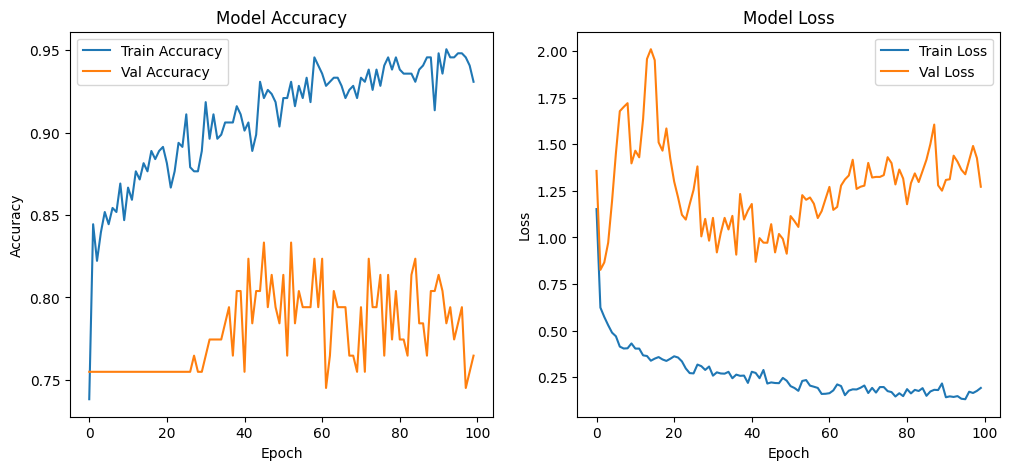

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()